In [1]:
# %%
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt 
import ipywidgets as widgets
import pandas as pd
from scipy.stats import nbinom
from GCRsim_v02f import CosmicRaySimulation

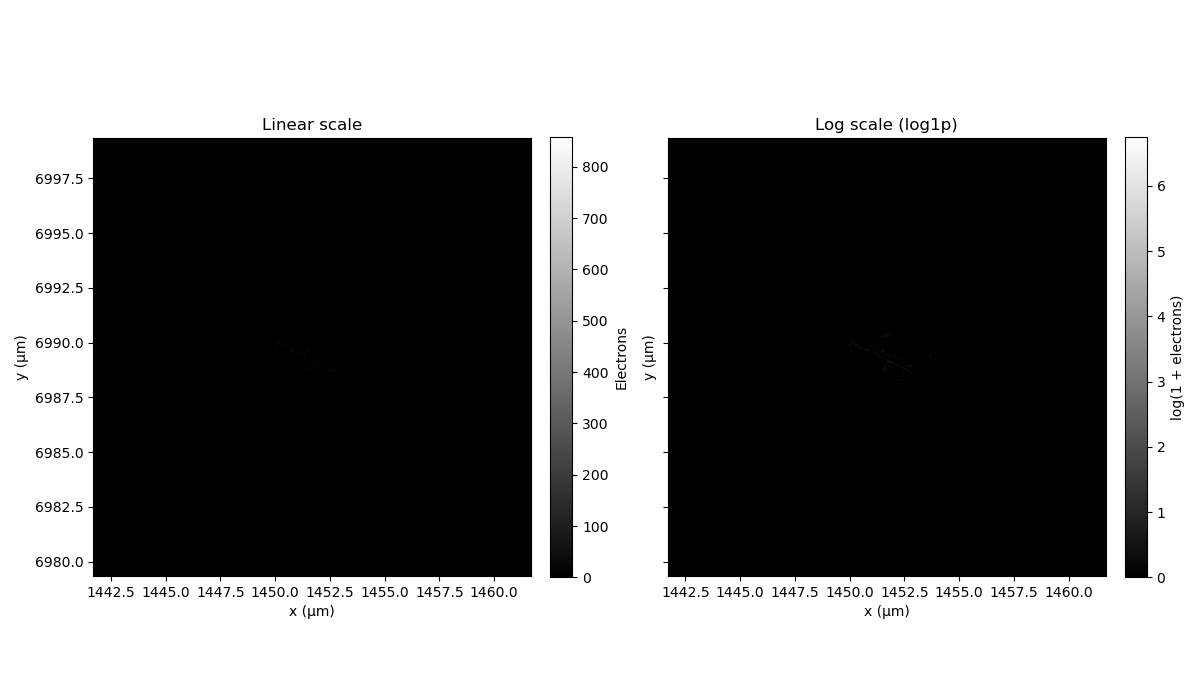

In [2]:

# ---- User Settings ----
csvfile = '202506242308_energy_loss_log.csv'
pixel_size = 10.0         # µm
grid_pixels = 2
window_size = grid_pixels * pixel_size  # 20 µm
bin_size = 0.01           # µm
nbins = int(window_size / bin_size)     # 2000
chunksize = 100_000

def electron_conversion(dE, f_eff=2.71, w=2.509):
    if dE <= 0:
        return 0
    dE = dE*1e6 # changing MeV to eV
    mu_nb = dE / w
    p = 1.0 / f_eff
    if not (0 < p < 1):
        return 0
    r = mu_nb * (p / (1.0 - p))
    if r <= 0:
        return 0
    return nbinom(r, p).rvs()

# Step 1: Find the first primary PID in the file
primary_pid = None
for chunk in pd.read_csv(csvfile, sep=',', chunksize=1):
    primary_pid = chunk['PID'].iloc[0]
    break

# Step 2: Collect all events for this primary (and its delta rays) as discrete electrons
x_electrons, y_electrons = [], []
x_events, y_events = [], []

for chunk in pd.read_csv(csvfile, sep=',', chunksize=chunksize):
    pids = chunk['PID'].to_numpy()
    xs = chunk['x'].to_numpy()
    ys = chunk['y'].to_numpy()
    dEs = chunk['dE'].to_numpy()
    parent_pids = np.array([CosmicRaySimulation.get_parent_pid(pid) for pid in pids])
    mask = (parent_pids == primary_pid)
    xs_sel = xs[mask]
    ys_sel = ys[mask]
    dEs_sel = dEs[mask]

    for x, y, dE in zip(xs_sel, ys_sel, dEs_sel):
        n_electrons = electron_conversion(dE)
        if n_electrons > 0:
            # Add for centroid calculation
            x_events.append(x)
            y_events.append(y)
            # For each electron, add individual (x, y)
            x_electrons.extend([x] * n_electrons)
            y_electrons.extend([y] * n_electrons)

if len(x_electrons) == 0:
    print("No electrons found for first primary PID!")
else:
    # Step 3: Center grid on mean event position (from events, not electrons)
    x0 = np.mean(x_events)
    y0 = np.mean(y_events)
    x_min = x0 - (window_size / 2)
    x_max = x0 + (window_size / 2)
    y_min = y0 - (window_size / 2)
    y_max = y0 + (window_size / 2)

    # Step 4: Mask electrons within the window
    x_electrons = np.array(x_electrons)
    y_electrons = np.array(y_electrons)
    mask_e = (x_electrons >= x_min) & (x_electrons < x_max) & (y_electrons >= y_min) & (y_electrons < y_max)
    xs_window = x_electrons[mask_e]
    ys_window = y_electrons[mask_e]

    # Step 5: Histogram (each electron = 1 count)
    H, xedges, yedges = np.histogram2d(
        xs_window, ys_window,
        bins=[nbins, nbins],
        range=[[x_min, x_max], [y_min, y_max]]
    )

    # Step 6: Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 7), sharex=True, sharey=True)

    # Linear plot
    im0 = axs[0].imshow(
        H.T,
        origin='lower',
        cmap='gray',
        extent=[x_min, x_max, y_min, y_max],
        aspect='equal'
    )
    axs[0].set_title('Linear scale')
    axs[0].set_xlabel('x (µm)')
    axs[0].set_ylabel('y (µm)')
    cbar0 = fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    cbar0.set_label('Electrons')

    # Log1p plot
    im1 = axs[1].imshow(
        np.log1p(H.T),
        origin='lower',
        cmap='gray',
        extent=[x_min, x_max, y_min, y_max],
        aspect='equal'
    )
    axs[1].set_title('Log scale (log1p)')
    axs[1].set_xlabel('x (µm)')
    axs[1].set_ylabel('y (µm)')
    cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    cbar1.set_label('log(1 + electrons)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [3]:

def block_average(arr, factor):
    # arr shape: (ny, nx)
    ny, nx = arr.shape
    ny_trim = ny - ny % factor  # ensure divisible
    nx_trim = nx - nx % factor
    arr = arr[:ny_trim, :nx_trim]
    return arr.reshape(ny_trim // factor, factor, nx_trim // factor, factor).mean(axis=(1, 3))

# If you want to use floor instead of mean:
def block_floor(arr, factor):
    ny, nx = arr.shape
    ny_trim = ny - ny % factor
    nx_trim = nx - nx % factor
    arr = arr[:ny_trim, :nx_trim]
    return arr.reshape(ny_trim // factor, factor, nx_trim // factor, factor).sum(axis=(1, 3)).astype(int)


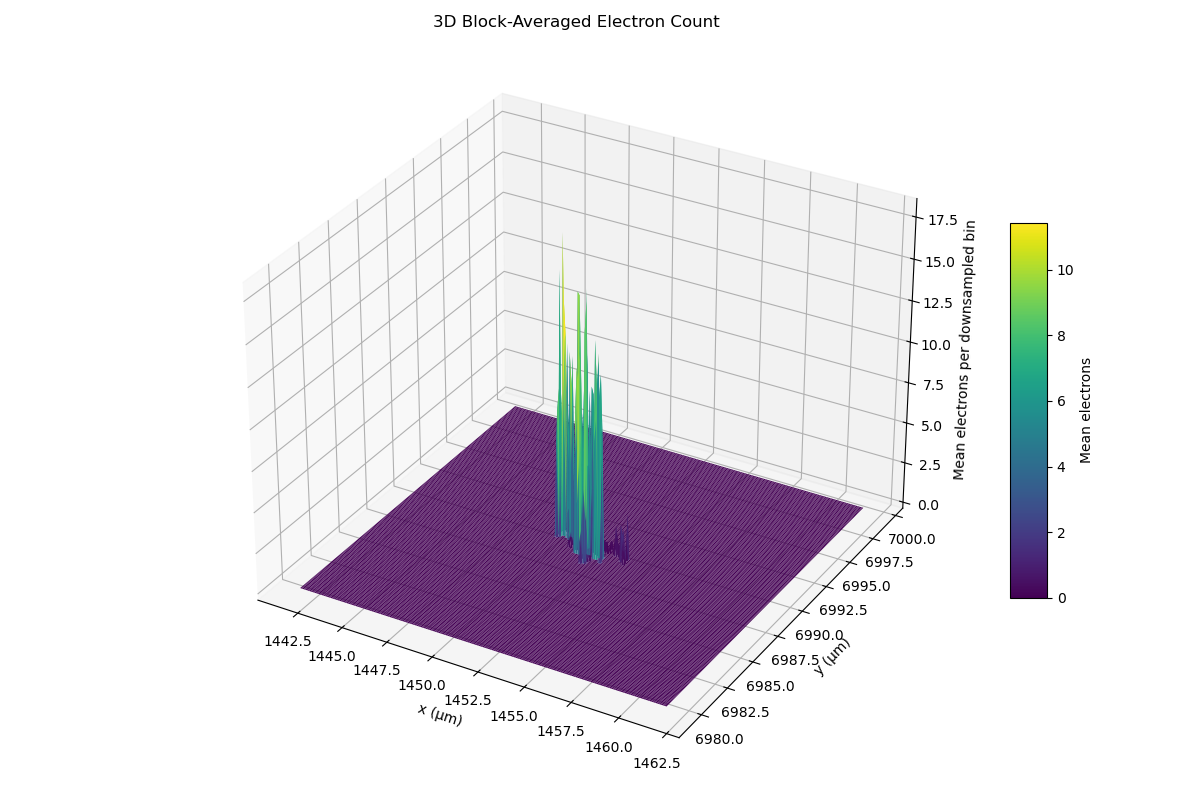

In [4]:
# Downsample with block averaging
downsample = 10
H3d = block_average(H, downsample)
nbins_x, nbins_y = H3d.shape

x = np.linspace(x_min, x_max, nbins_x)
y = np.linspace(y_min, y_max, nbins_y)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, H3d.T, cmap='viridis', edgecolor='none', rstride=1, cstride=1, antialiased=True)
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')
ax.set_zlabel('Mean electrons per downsampled bin')
ax.set_title('3D Block-Averaged Electron Count')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Mean electrons')
plt.tight_layout()
plt.show()


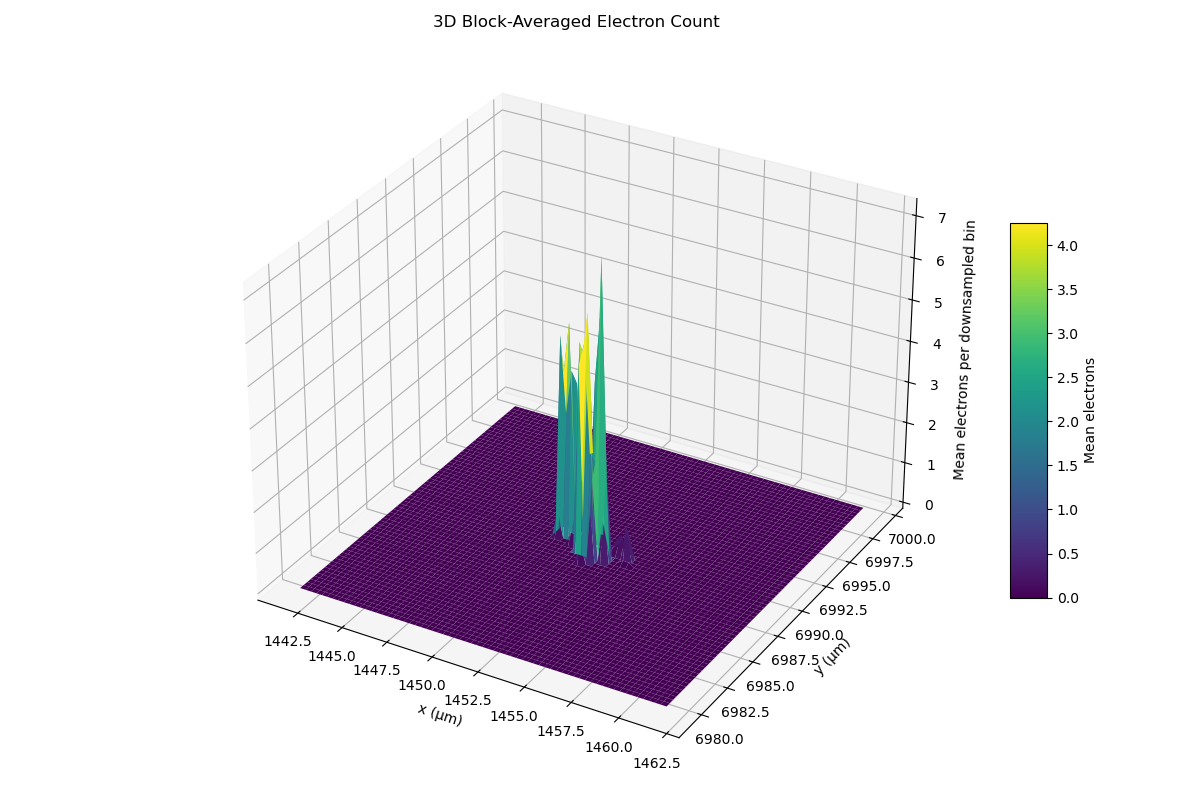

In [5]:
# Downsample with block averaging
downsample = 30
H3d = block_average(H, downsample)
nbins_x, nbins_y = H3d.shape

x = np.linspace(x_min, x_max, nbins_x)
y = np.linspace(y_min, y_max, nbins_y)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, H3d.T, cmap='viridis', edgecolor='none', rstride=1, cstride=1, antialiased=True)
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')
ax.set_zlabel('Mean electrons per downsampled bin')
ax.set_title('3D Block-Averaged Electron Count')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Mean electrons')
plt.tight_layout()
plt.show()
